# Looking at Day 24
My solution to this relied on an invariant

```
(Vi-Vj)×(Pi-Pj)⋅P = (Vi-Vj)⋅Pi×Pj
```

I want to see the hailstone vectors, and see my solution vectors, and
try to make sense of this invariant. What does it mean?

## Load input data

In [2]:
from aoc2023.__main__ import get_input_file_lines

In [3]:
get_input_file_lines?

Signature: get_input_file_lines(day: str | int) -> Iterable[str]
Docstring: <no docstring>
File:      ~/repos/advent-of-code/aoc2023/util.py
Type:      function

In [38]:
input_lines = get_input_file_lines(24)

In [39]:
line_g = (line.split(" @ ") for line in input_lines if line)
stones = tuple(
    (
        tuple(int(p) for p in pos.split(", ")),
        tuple(int(v) for v in vel.split(", "))
    )
    for pos, vel in line_g
    if line_g
)
stones[10:12]

(((292048304292386, 197291170834422, 202943740926287), (-72, -10, -55)),
 ((311130681683078, 306087457111806, 249396912802046), (-6, 76, 88)))

In [40]:
P, V = zip(*stones)

In [41]:
from random import randint
idx = randint(0, len(P))
P[idx], V[idx]

((303723250807823, 136790096764317, 194195804444633), (-98, 265, 20))

In [42]:
Px, Py, Pz = zip(*P)
Vx, Vy, Vz = zip(*V)

In [47]:
idx = randint(0, len(P))
(Px[idx], Py[idx], Pz[idx]), (Vx[idx], Vy[idx], Vz[idx])

((339404627137859, 255726487879449, 286028848839425), (-68, 79, -12))

## Try to plot input data

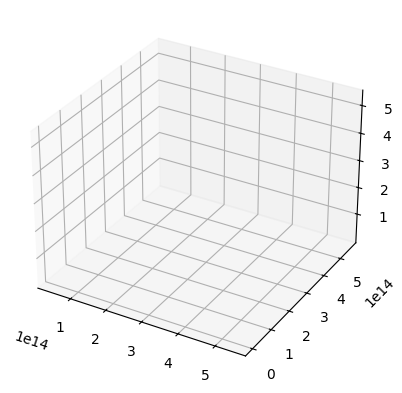

In [45]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.quiver(Px, Py, Pz, Vx, Vy, Vz);

Ok, let's think about this. I don't want to plot all the hailstones.
If I'm looking at the invariant I really want to plot a pair
of hailstones, right? Right. So let's pick a pair and see what we see.

In [54]:
P, V = zip(*stones)
Px, Py, Pz = zip(*P)
Vx, Vy, Vz = zip(*V)

In [56]:
# I could use a mask to just plot these but I don't remember how
Px_plot, Py_plot, Pz_plot = zip(P[zero], P[one])
Vx_plot, Vy_plot, Vz_plot = zip(V[zero], V[one])

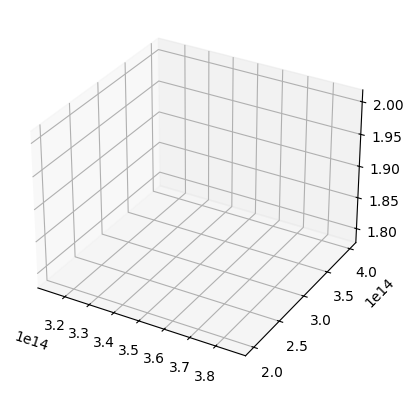

In [57]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.quiver(Px_plot, Py_plot, Pz_plot, Vx_plot, Vy_plot, Vz_plot);

Still can't see anything. The positions are too far away from each other, and the velocities are too small relative to the positions.

What if we scale all the positions down by $10^{12}$?

...also let's use numpy for these arrays.
Don't know why I didn't think of that before.

In [60]:
import numpy as np
P, V = np.array(P), np.array(V)
P[(zero, one),]

array([[386078415778781, 398937650617401, 178190383185251],
       [314040985818041, 198787884224072, 201315974078157]])

In [70]:
mask = [zero, one]

In [71]:
print(P.shape)
print(P[mask].shape)

(300, 3)
(2, 3)


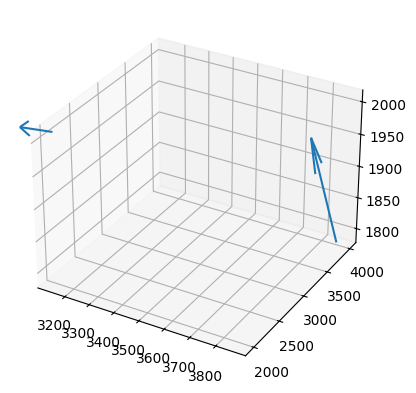

In [75]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.quiver(
    P[mask, 0]/10**11,
    P[mask, 1]/10**11,
    P[mask, 2]/10**11,
    V[mask, 0],
    V[mask, 1],
    V[mask, 2]
);

This looks kinda reasonable.

## Calculate pairwise products
We need to find the differences of vectors i, j
```
V[i] - V[j]
```
and
```
P[i] - P[j]
```
Then we need to take products
```
(V[i] - V[j])×(P[i] - P[j])
```
and 
```
P[i]×P[j]
```
These are the things I want to plot and look at.

In [173]:
n = P.shape[0]
tri_idx = np.triu_indices(n)

In [174]:
Pmat = np.tile(P.reshape(n, 3, 1), (1, 1, n)).swapaxes(1, 2)
Pdiff = np.zeros(Pmat.shape, dtype=np.int64)
Pdiff[tri_idx[0], tri_idx[1], :] = \
    Pmat[tri_idx[0], tri_idx[1], :] \
    - Pmat.transpose((1, 0, 2))[tri_idx[0], tri_idx[1], :]

In [175]:
Vmat = np.tile(V.reshape(n, 3, 1), (1, 1, n)).swapaxes(1, 2)
Vdiff = np.zeros(Vmat.shape, dtype=np.int64)
Vdiff[tri_idx[0], tri_idx[1], :] = \
    Vmat[tri_idx[0], tri_idx[1], :] \
    - Vmat.transpose((1, 0, 2))[tri_idx[0], tri_idx[1], :]

In [176]:
VcrossP = np.cross(Vdiff, Pdiff)

In [177]:
Pcross = np.zeros(Pmat.shape, dtype=np.int64)
Pcross[tri_idx[0], tri_idx[1], :] = np.cross(
    Pmat[tri_idx[0], tri_idx[1], :],
    Pmat.transpose((1, 0, 2))[tri_idx[0], tri_idx[1], :]
)

What do I actually want to plot here?
I think maybe I'd like to look at `P[i]` and `P[j]` as vectors
from the origin, then also `V[i]` and `V[j]` as vectors from `P`,
plus the solution vector, the cross products...  
Pretty much everything.

Could probably quickly reimpliment my solution in numpy.

In [178]:
from random import randint
zero, one, two = 0, 0, 0
while zero == one or one == two:
    zero, one, two = sorted(randint(0, n) for _ in range(3))
zero, one, two

(17, 205, 222)

In [179]:
C = np.stack((
    VcrossP[zero, one, :],
    VcrossP[zero, two, :],
    VcrossP[one, two, :],
), axis=0, dtype=np.int64)
C

array([[  4442878074264894,  -1393145170251296,   1438815974073500],
       [-32031437627762421,  16180087730720657, -25937918614427842],
       [-34433364618247000,  12758810414265825, -23327910738192725]])

In [180]:
D = np.array((
    np.dot(Vdiff[zero, one, :], Pcross[zero, one, :]),
    np.dot(Vdiff[zero, two, :], Pcross[zero, two, :]),
    np.dot(Vdiff[one, two, :], Pcross[one, two, :]),
), dtype=np.int64)
D

array([-4432873357814127558,  4822858370737189698,  3429020738838189634])

In [181]:
P0 = np.array((267365104480541, 139405790744697, 147898020991907), dtype=np.int64)
np.matmul(C, P0) == D

array([ True,  True,  True])

In [191]:
Ps = P - np.tile(P0, n).reshape(n, 3)

In [232]:
scale = np.mean(Ps[(zero, one, two), :])/250
scale

329585326001.66974

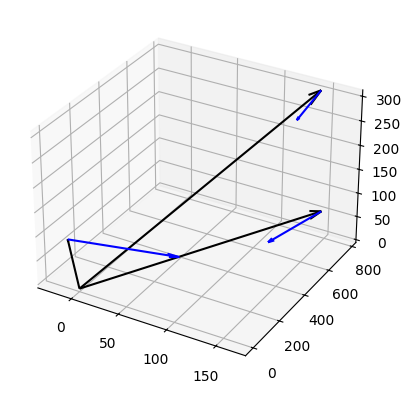

In [233]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Ps
black = (0, 0, 0, 1)
origin = np.zeros((1, 3))
ax.quiver(
    origin,
    origin,
    origin,
    Ps[(zero, one, two), 0]/scale,
    Ps[(zero, one, two), 1]/scale,
    Ps[(zero, one, two), 2]/scale,
    colors=(black, black, black),
    arrow_length_ratio=0.05
);

# Vs
blue = (0, 0, 1, 1)
ax.quiver(
    Ps[(zero, one, two), 0]/scale,
    Ps[(zero, one, two), 1]/scale,
    Ps[(zero, one, two), 2]/scale,
    V[(zero, one, two), 0],
    V[(zero, one, two), 1],
    V[(zero, one, two), 1],
    colors=(blue, blue, blue),
    arrow_length_ratio=0.1
);

In [234]:
Vdiff[(zero, zero, one), (one, two, two), :]

array([[  28,   17,  -70],
       [-131,  -83,  110],
       [-159, -100,  180]])

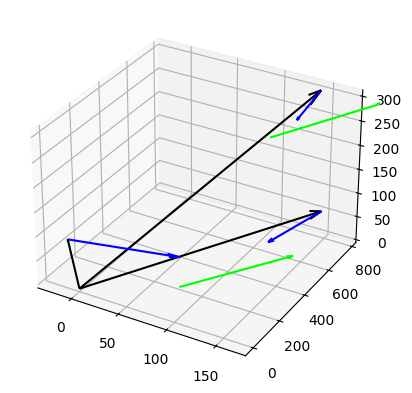

In [250]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Ps
ax.quiver(
    origin,
    origin,
    origin,
    Ps[(zero, one, two), 0]/scale,
    Ps[(zero, one, two), 1]/scale,
    Ps[(zero, one, two), 2]/scale,
    colors=(black, black, black),
    arrow_length_ratio=0.05
);

# Vs
blue = (0, 0, 1, 1)
ax.quiver(
    Ps[(zero, one, two), 0]/scale,
    Ps[(zero, one, two), 1]/scale,
    Ps[(zero, one, two), 2]/scale,
    V[(zero, one, two), 0],
    V[(zero, one, two), 1],
    V[(zero, one, two), 1],
    colors=(blue, blue, blue),
    arrow_length_ratio=0.1
);

# # Pdiff
# red = (1, 0, 0, 1)
# ax.quiver(
#     Ps[(one, two, two), 0]/scale,
#     Ps[(one, two, two), 1]/scale,
#     Ps[(one, two, two), 2]/scale,
#     Pdiff[(zero, zero, one), (one, two, two), 0]/scale,
#     Pdiff[(zero, zero, one), (one, two, two), 1]/scale,
#     Pdiff[(zero, zero, one), (one, two, two), 2]/scale,
#     colors=(red, red, red),
#     arrow_length_ratio=0.05
# );

# # Vdiff
# green = (0, 1, 0, 1)
# ax.quiver(
#     Ps[(one, two, two), 0]/scale + V[(one, two, two), 0],
#     Ps[(one, two, two), 1]/scale + V[(one, two, two), 1],
#     Ps[(one, two, two), 2]/scale + V[(one, two, two), 2],
#     # Pdiff[(zero, zero, one), (one, two, two), 0]/scale + Vdiff[(zero, zero, one), (one, two, two), 0],
#     # Pdiff[(zero, zero, one), (one, two, two), 1]/scale + Vdiff[(zero, zero, one), (one, two, two), 1],
#     # Pdiff[(zero, zero, one), (one, two, two), 2]/scale + Vdiff[(zero, zero, one), (one, two, two), 2],
#     100*np.ones(3),
#     100*np.ones(3),
#     100*np.ones(3),
#     colors=(green, green, green),
#     arrow_length_ratio=0.05
# );

# Vdiff
green = (0, 1, 0, 1)
ax.quiver(
    (Ps[(one, two), :]/scale + V[(one, two), :]).transpose()[0],
    (Ps[(one, two), :]/scale + V[(one, two), :]).transpose()[1],
    (Ps[(one, two), :]/scale + V[(one, two), :]).transpose()[2],
    # Pdiff[(zero, zero, one), (one, two, two), 0]/scale + Vdiff[(zero, zero, one), (one, two, two), 0],
    # Pdiff[(zero, zero, one), (one, two, two), 1]/scale + Vdiff[(zero, zero, one), (one, two, two), 1],
    # Pdiff[(zero, zero, one), (one, two, two), 2]/scale + Vdiff[(zero, zero, one), (one, two, two), 2],
    100*np.ones(2),
    100*np.ones(2),
    100*np.ones(2),
    colors=(green, green),
    arrow_length_ratio=0.05
);


In [257]:
V[(one, two), :]

array([[-45, -74, 144],
       [114,  26, -36]])

In [259]:
Ps[(one, two), :]/scale

array([[165.76906313, 634.16304384, 102.16000402],
       [-22.50479274,  70.59722655,  71.83036588]])

In [260]:
Ps[(one, two), :]/scale + V[(one, two), :]

array([[120.76906313, 560.16304384, 246.16000402],
       [ 91.49520726,  96.59722655,  35.83036588]])

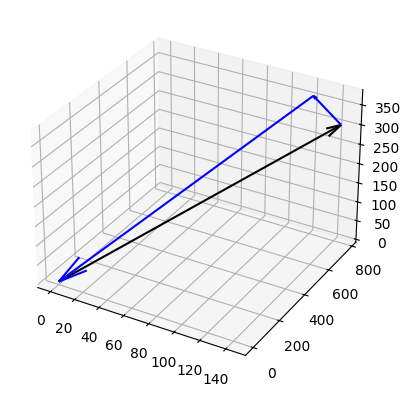

In [264]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.quiver(
    0,
    0,
    0,
    Ps[zero, 0]/scale,
    Ps[zero, 1]/scale,
    Ps[zero, 2]/scale,
    colors=(black,),
    arrow_length_ratio=0.05
);

ax.quiver(
    Ps[zero, 0]/scale,
    Ps[zero, 1]/scale,
    Ps[zero, 2]/scale,
    V[zero, 0],
    V[zero, 1],
    V[zero, 2],
    colors=(blue,),
    arrow_length_ratio=0.1
);
ax.quiver(
    Ps[zero, 0]/scale + V[zero, 0],
    Ps[zero, 1]/scale + V[zero, 1],
    Ps[zero, 2]/scale + V[zero, 2],
    -(Ps[zero, 0]/scale + V[zero, 0]),
    -(Ps[zero, 1]/scale + V[zero, 1]),
    -(Ps[zero, 2]/scale + V[zero, 2]),
    colors=(blue,),
    arrow_length_ratio=0.1
);
